In [1]:
import utils.torch_resistance_metrics as ermet
import utils.data_loader as loader
import torch
import torch_geometric as pyg
import os
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
DATASET = ['facebook', 'UNC28', 'google']#[2]
DATASET

['facebook', 'UNC28', 'google']

In [3]:
def get_groups(data): 
    if data == 'google':
        rename_groups = {
            1:'Male',
            0:'Female',
        }
        male=1
        female=0
    else:
        rename_groups = {
            1:'Female',
            0:'Male'
        }
        male=0
        female=1
    return rename_groups, male, female

data_names = {'facebook': 'Facebook', 'UNC28': 'UNC28', 'google': 'Google+'}

In [4]:
wrappers = {}
for data in DATASET:
    print(data)
    wrappers[data] = loader.load_data(dataset = data, device = 'cpu')
    print(wrappers[data].num_edges, wrappers[data].num_nodes)

facebook
Loaded Graph with 1034 nodes and 26749 edges - L computation mode: exact
26749 1034
UNC28
Loaded Graph with 3985 nodes and 65287 edges - L computation mode: exact
65287 3985
google
Loaded Graph with 3508 nodes and 253930 edges - L computation mode: exact
253930 3508


In [5]:
for data in DATASET:
    print(data.upper())
    rename_groups, male, female = get_groups(data)
    GW = wrappers[data] #GW = loader.load_data(dataset = data, device = 'cpu')

    unique_values, counts = torch.unique(GW.sens, return_counts=True)
    unique_counts_dict = dict(zip(unique_values.tolist(), counts.tolist()))
    gender_count = {rename_groups[k]: v for k, v in unique_counts_dict.items()}

    print(unique_counts_dict)
    print(gender_count)
    print("Male Rtot:   ", GW.get_effective_resistance().sum(axis=0)[GW.sens==male].mean().item())
    print("Female Rtot: ", GW.get_effective_resistance().sum(axis=0)[GW.sens==female].mean().item())
    print()
    

FACEBOOK
{0.0: 685, 1.0: 349}
{'Male': 685, 'Female': 349}
Male Rtot:    179.8131561279297
Female Rtot:  221.43218994140625

UNC28
{0.0: 2307, 1.0: 1678}
{'Male': 2307, 'Female': 1678}
Male Rtot:    586.2865600585938
Female Rtot:  608.6563110351562

GOOGLE
{0.0: 2196, 1.0: 1312}
{'Female': 2196, 'Male': 1312}
Male Rtot:    287.6490783691406
Female Rtot:  564.0778198242188



In [6]:
GW.edgelist

tensor([[   0,    0,    0,  ..., 3507, 3507, 3507],
        [  26,  108,  139,  ..., 3385, 3402, 3461]])

FACEBOOK
Mean degree: 51.74, 53498.00 edges, 26749 edges in the graph


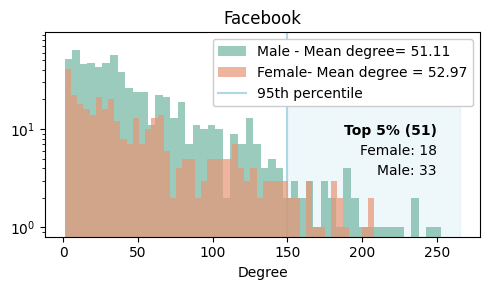

UNC28
Mean degree: 32.77, 130574.00 edges, 65287 edges in the graph


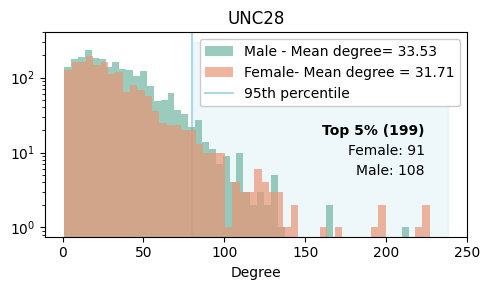

GOOGLE
Mean degree: 144.77, 507860.00 edges, 253930 edges in the graph


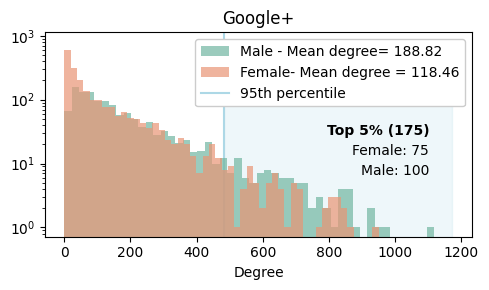

In [32]:
for data in DATASET:
    print(data.upper())
    rename_groups, male, female = get_groups(data)
    GW = wrappers[data] #GW = loader.load_data(dataset = data, device = 'cpu')
    N = GW.num_nodes
    

    #compute degrees
    edge_list = GW.edgelist
    degrees = pyg.utils.degree(edge_list[0], num_nodes=GW.num_nodes)

    #plot degree distribution
    mean_degree = degrees.mean().item()
    print(f"Mean degree: {mean_degree:.2f}, {degrees.sum().item():.2f} edges, {GW.num_edges} edges in the graph")

    mean_male_degree = degrees[GW.sens==male].mean().item()
    std_male_degree  = degrees[GW.sens==male].std().item()

    mean_female_degree = degrees[GW.sens==female].mean().item()
    std_female_degree  = degrees[GW.sens==female].std().item()

    k = int(N*0.05)
    top_degrees = torch.argsort(degrees, descending=True)[:k]
    unique_values, counts = torch.unique(GW.sens[top_degrees], return_counts=True)
    unique_counts_dict = dict(zip(unique_values.tolist(), counts.tolist()))
    if data=='google':
        top_gender_count = {rename_groups[k]: v for k, v in unique_counts_dict.items()}
    else:
        top_gender_count = {rename_groups[k]: v for k, v in list(unique_counts_dict.items())[::-1]}
    
    plt.figure(figsize=(5,3))
    ax = plt.gca()
    plt.hist(degrees[GW.sens==male], bins=50, log=True, alpha=0.7, label=f'Male - Mean degree= {mean_male_degree:.2f}', color='#71B6A1')
    plt.hist(degrees[GW.sens==female], bins=50, log=True, alpha=0.7, label=f'Female- Mean degree = {mean_female_degree:.2f}', color='#E99575')

    plt.axvline(degrees[top_degrees].min(), color='lightblue', zorder=0, label='95th percentile')
    #fill between the two lines
    plt.fill_betweenx([0,plt.ylim()[1]], degrees[top_degrees].min(), plt.xlim()[1], color='lightblue', alpha=0.2, zorder=0)
    #write top gender count in text at right of the line
    plt.text(#(degrees[top_degrees].min()-plt.xlim()[0])/(plt.xlim()[1]-plt.xlim()[0])+0.03, 0.6,
             .9,0.5,
              f"Top 5% ({k})", fontsize=10, fontweight='bold', transform=ax.transAxes, ha='right')
    for i, (group, count) in enumerate(top_gender_count.items()):
        plt.text(#(degrees[top_degrees].min()-plt.xlim()[0])/(plt.xlim()[1]-plt.xlim()[0])+0.03, 0.5-i*0.1,
                .9,0.4-i*0.1,
                 f'{group}: {count}', fontsize=10, transform=ax.transAxes, ha='right')


    plt.title(data_names[data])
    plt.xlabel('Degree')
    plt.legend(framealpha=1,)
    plt.tight_layout()
    plt.savefig(f'data_figs/{data}-degree-distribution.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [8]:
for data in []:# DATASET[:]:
    print(data.upper())
    rename_groups, male, female = get_groups(data)
    GW = wrappers[data] #GW = loader.load_data(dataset = data, device = 'cpu')
    N = GW.num_nodes
    
    G = nx.from_edgelist(GW.edgelist.T.numpy())
    nx.set_node_attributes(G, {i:GW.sens[i].item() for i in range(GW.num_nodes)}, 'sens')

    closeness_cent = nx.closeness_centrality(G)
    closeness_cent_np = np.array([closeness_cent[i] for i in range(GW.num_nodes)])

    np.save(f'data_figs/save-data/{data}-closeness-centrality.npy', np.vstack((GW.sens.numpy(),closeness_cent_np)))

    plt.figure(figsize=(5,3))
    ax = plt.gca()
    if data=='google':
        plt.hist(closeness_cent_np[GW.sens==female], bins=40, alpha=0.7, color='#E99575', label='Female')
        plt.hist(closeness_cent_np[GW.sens==male], bins=40, alpha=0.7, color='#71B6A1', label='Male')
    else:
        plt.hist(closeness_cent_np[GW.sens==male], bins=40, alpha=0.7, color='#71B6A1',label='Male')
        plt.hist(closeness_cent_np[GW.sens==female], bins=40, alpha=0.7, color='#E99575', label='Female')
    plt.axvline(closeness_cent_np[GW.sens==male].mean(), color='green')
    plt.axvline(closeness_cent_np[GW.sens==female].mean(), color='orange') 
    plt.title(data_names[data])
    plt.xlabel('Closeness Centrality')
    plt.legend(framealpha=1,)
    plt.tight_layout()
    plt.savefig(f'data_figs/{data}-closeness-centrality.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [9]:
for data in []:# DATASET[:1]:
    print(data.upper())
    rename_groups, male, female = get_groups(data)
    GW = wrappers[data] #GW = loader.load_data(dataset = data, device = 'cpu')
    N = GW.num_nodes
    
    G = nx.from_edgelist(GW.edgelist.T.numpy())
    nx.set_node_attributes(G, {i:GW.sens[i].item() for i in range(GW.num_nodes)}, 'sens')

    bet_cent = nx.betweenness_centrality(G)
    bet_cent_np = np.array([bet_cent[i] for i in range(GW.num_nodes)])

    np.save(f'data_figs/save-data/{data}-betweenness-centrality.npy', np.vstack((GW.sens.numpy(),bet_cent_np)))

    plt.figure(figsize=(5,3))
    ax = plt.gca()
    if data=='google':
        plt.hist(bet_cent_np[GW.sens==female], bins=40, alpha=0.7, color='#E99575', label='Female', log=True)
    plt.hist(bet_cent_np[GW.sens==male], bins=40, alpha=0.7, color='#71B6A1',label='Male', log=True)
    if data!='google':
        plt.hist(bet_cent_np[GW.sens==female], bins=40, alpha=0.7, color='#E99575', label='Female')
    plt.axvline(bet_cent_np[GW.sens==male].mean(), color='green')
    plt.axvline(bet_cent_np[GW.sens==female].mean(), color='orange') 
    plt.title(data_names[data])
    plt.xlabel('Betweenness Centrality')
    plt.legend(framealpha=1,)
    plt.tight_layout()
    plt.savefig(f'data_figs/{data}-betweenness-centrality.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

FACEBOOK


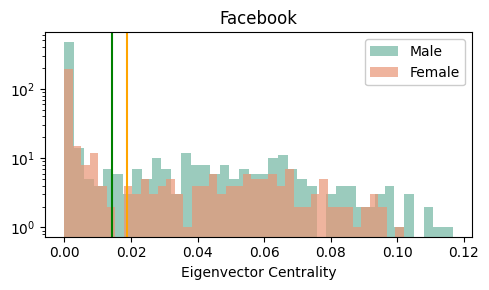

UNC28


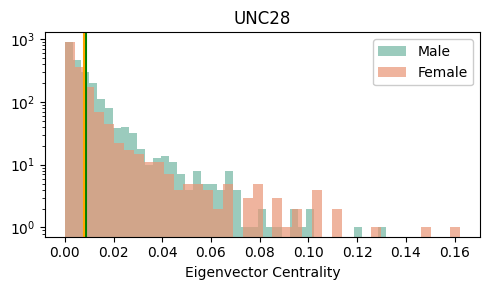

GOOGLE


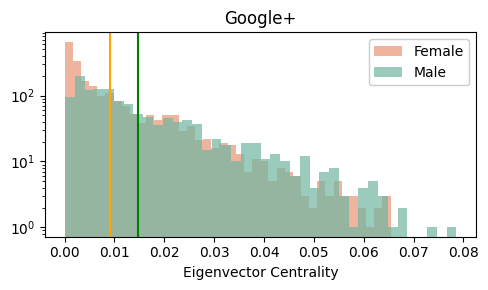

In [21]:
for data in DATASET:
    print(data.upper())
    rename_groups, male, female = get_groups(data)
    GW = wrappers[data] #GW = loader.load_data(dataset = data, device = 'cpu')
    N = GW.num_nodes
    
    G = nx.from_edgelist(GW.edgelist.T.numpy())
    nx.set_node_attributes(G, {i:GW.sens[i].item() for i in range(GW.num_nodes)}, 'sens')

    bet_cent = nx.eigenvector_centrality(G, max_iter=200)
    bet_cent_np = np.array([bet_cent[i] for i in range(GW.num_nodes)])

    np.save(f'data_figs/save-data/{data}-eigen-centrality.npy', np.vstack((GW.sens.numpy(),bet_cent_np)))

    plt.figure(figsize=(5,3))
    ax = plt.gca()
    if data=='google':
        plt.hist(bet_cent_np[GW.sens==female], bins=40, alpha=0.7, color='#E99575', label='Female', log=True)
    plt.hist(bet_cent_np[GW.sens==male], bins=40, alpha=0.7, color='#71B6A1',label='Male', log=True)
    if data!='google':
        plt.hist(bet_cent_np[GW.sens==female], bins=40, alpha=0.7, color='#E99575', label='Female')
    plt.axvline(bet_cent_np[GW.sens==male].mean(), color='green')
    plt.axvline(bet_cent_np[GW.sens==female].mean(), color='orange') 
    plt.title(data_names[data])
    plt.xlabel('Eigenvector Centrality')
    plt.legend(framealpha=1,)
    plt.tight_layout()
    plt.savefig(f'data_figs/{data}-eigen-centrality.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

**Proposed metrics**

In [11]:
for data in []:# DATASET:
    print(data.upper())
    rename_groups, male, female = get_groups(data)
    GW = wrappers[data] #GW = loader.load_data(dataset = data, device = 'cpu')
    N = GW.num_nodes
    R = GW.get_effective_resistance()

    cent = R.sum(axis=0)

    plt.figure(figsize=(5,3))
    ax = plt.gca()
    if data=='google':
        plt.hist(cent[GW.sens==female], bins=40, alpha=0.7, color='#E99575', label='Female', log=True)
    plt.hist(cent[GW.sens==male], bins=40, alpha=0.7, color='#71B6A1',label='Male', log=True)
    if data!='google':
        plt.hist(cent[GW.sens==female], bins=40, alpha=0.7, color='#E99575', label='Female')
    plt.axvline(cent[GW.sens==male].mean(), color='green')
    plt.axvline(cent[GW.sens==female].mean(), color='orange') 
    plt.title(data_names[data])
    plt.xlabel('Centrality')
    plt.legend(framealpha=1,)
    plt.tight_layout()
    #plt.savefig(f'data_figs/{data}-eigen-centrality.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [12]:
#save dataset for gephi with de sens feature
for data in DATASET:
    rename_groups, male, female = get_groups(data)
    GW = wrappers[data] #GW = loader.load_data(dataset = data, device = 'cpu')
    N = GW.num_nodes
    Rtot = GW.get_effective_resistance().sum(axis=0)
    G = nx.from_edgelist(GW.edgelist.T.numpy())
    nx.set_node_attributes(G, {i:GW.sens[i].item() for i in range(GW.num_nodes)}, 'sens')
    nx.set_node_attributes(G, {i:Rtot[i].item() for i in range(GW.num_nodes)}, 'Rtot')

    nx.write_gexf(G, f'data_figs/{data}.gexf')

tensor([0, 1, 0,  ..., 1, 0, 1])

**Homophily**

In [20]:
for data in DATASET:
    wrap = wrappers[data]
    h_n = pyg.utils.homophily(wrap.edgelist, wrap.sens.to(int), method='node')
    h_e = pyg.utils.homophily(wrap.edgelist, wrap.sens.to(int), method='edge')
    h_c = pyg.utils.homophily(wrap.edgelist, wrap.sens.to(int), method='edge_insensitive')

    print(f"""{data.upper()}: homophily node: {h_n:.2f}, homophily edge: {h_e:.2f}, homophily edge insensitive: {h_c:.2f}""")

FACEBOOK: homophily node: 0.61, homophily edge: 0.58, homophily edge insensitive: 0.06
UNC28: homophily node: 0.57, homophily edge: 0.55, homophily edge insensitive: 0.08
GOOGLE: homophily node: 0.51, homophily edge: 0.51, homophily edge insensitive: 0.12
